# Training a FNO on the Shallow Water equations


In [24]:
import time
import sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange


## Inital condition: Gauss function

Load data from h5 file.

In [25]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\torotest1_t7.h5', 'r') as file:
    # List all datasets in the file, skipping meta-entries
    for key in file.keys():
        print(key)
        # Check if each key is a group or dataset
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

        h_all = np.array(file['data_0']['hexact_all'])
        time_all = np.array(file['data_0']['time_all'])
        u_all = np.array(file['data_0']['uexact_all'])
        x = np.array(file['data_0']['xexact'])

        print(f"'h_all' loaded with shape: {h_all.shape}")
        print(f"'u_all' loaded with shape: {u_all.shape}")
        print(f"'time_all' loaded with shape: {time_all.shape}")
        print(f"'x' loaded with shape: {x.shape}")



data_0
  'data_0' is a group containing:
    hexact_all
    time_all
    uexact_all
    xexact
'h_all' loaded with shape: (95, 201)
'u_all' loaded with shape: (95, 201)
'time_all' loaded with shape: (95, 1)
'x' loaded with shape: (1, 201)


In [26]:
#plt.plot(h_all[-1,:]),

In [27]:
def prepare_data(h_all, x, p_train, p_val):
    x = x.squeeze()
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :]
    # Target u (one time step after a)
    u = h_all[1:]
    u = u[:, np.newaxis, :]

    mesh = x.copy()
    mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)

    # Concatenate a with mesh_shape_corrected
    a_with_mesh = np.concatenate([a, mesh_shape_corrected], axis=1)
    print(a_with_mesh.shape)

    # Concatenate u with mesh_shape_corrected
    u_with_mesh = np.concatenate([u, mesh_shape_corrected], axis=1)
    print(u_with_mesh.shape)

    n = len(a_with_mesh)
    print(n)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


In [28]:
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, x, p_train, p_val)

(94, 2, 201)
(94, 2, 201)
94
n_train = 56, n_val = 18, n_test = 20
torch.Size([56, 1, 201]) torch.Size([56, 1, 201]) torch.Size([18, 1, 201]) torch.Size([18, 1, 201]) torch.Size([20, 1, 201]) torch.Size([20, 1, 201])


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [30]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 308929 parameters.


In [31]:
def dataloader_torch(dataset_x,dataset_y,batch_size,):
    dataset = torch.utils.data.TensorDataset(dataset_x, dataset_y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

learn_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)
dataloader_train = dataloader_torch(train_x, train_y, batch_size=16)

In [32]:
n_epochs = 100

loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)
for epoch in tqdm(range(n_epochs), unit='epoch'):
    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = torch.mean((y_pred - y) ** 2)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        with torch.no_grad():
            val_x, val_y = val_x.to(device), val_y.to(device)
            validation_loss = torch.mean((model(val_x) - val_y) ** 2).item()
            loss_val.append(validation_loss)
            # save model weighs if validation loss is minimal
            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                #torch.save(model.state_dict(), f"best_model_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pth")
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(validation_loss)
    else:
        scheduler.step()


  0%|          | 0/100 [00:00<?, ?epoch/s]

Plot training and validation loss. Iteration = n_epochs x n_batches.

In [ ]:
save = 0

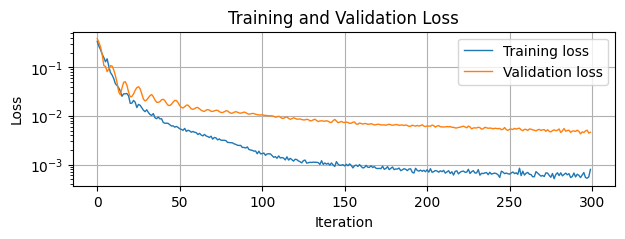

In [34]:
plt.figure(figsize=(7, 2))
plt.plot(loss_train, label='Training loss', linewidth=1)
plt.plot(loss_val, label='Validation loss', linewidth=1)
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

if save:
    plt.savefig(f'plots/torotest1_loss_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()

(94, 1, 201)


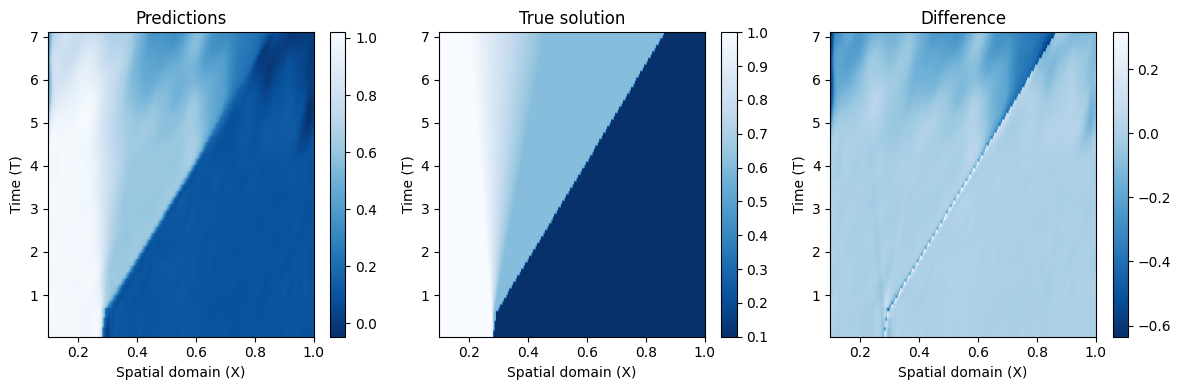

In [35]:
# Assuming x and time_all correspond to the spatial and time dimensions
X, T = np.meshgrid(x, time_all.squeeze())

# Make predictions
pred_train = model(train_x).cpu().detach().numpy()
pred_val = model(val_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Plot predictions
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

cmap = 'Blues_r'

# Define the extent based on X and T
extent = [X.min(), X.max(), T.max(), T.min()]  

# Prediction plot
im1 = ax[0].imshow(pred_all[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[0].set_title("Predictions")
ax[0].set_xlabel("Spatial domain (X)")
ax[0].set_ylabel("Time (T)")
ax[0].invert_yaxis()
plt.colorbar(im1, ax=ax[0])

# True solution plot
im2 = ax[1].imshow(u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[1].set_title("True solution")
ax[1].set_xlabel("Spatial domain (X)")
ax[1].set_ylabel("Time (T)")
ax[1].invert_yaxis()
plt.colorbar(im2, ax=ax[1])

# Difference plot
im3 = ax[2].imshow(pred_all[:, 0, :] - u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[2].set_title("Difference")
ax[2].set_xlabel("Spatial domain (X)")
ax[2].set_ylabel("Time (T)")
ax[2].invert_yaxis()
plt.colorbar(im3, ax=ax[2])

plt.tight_layout()

if save:
    plt.savefig(f'plots/torotest1_pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()



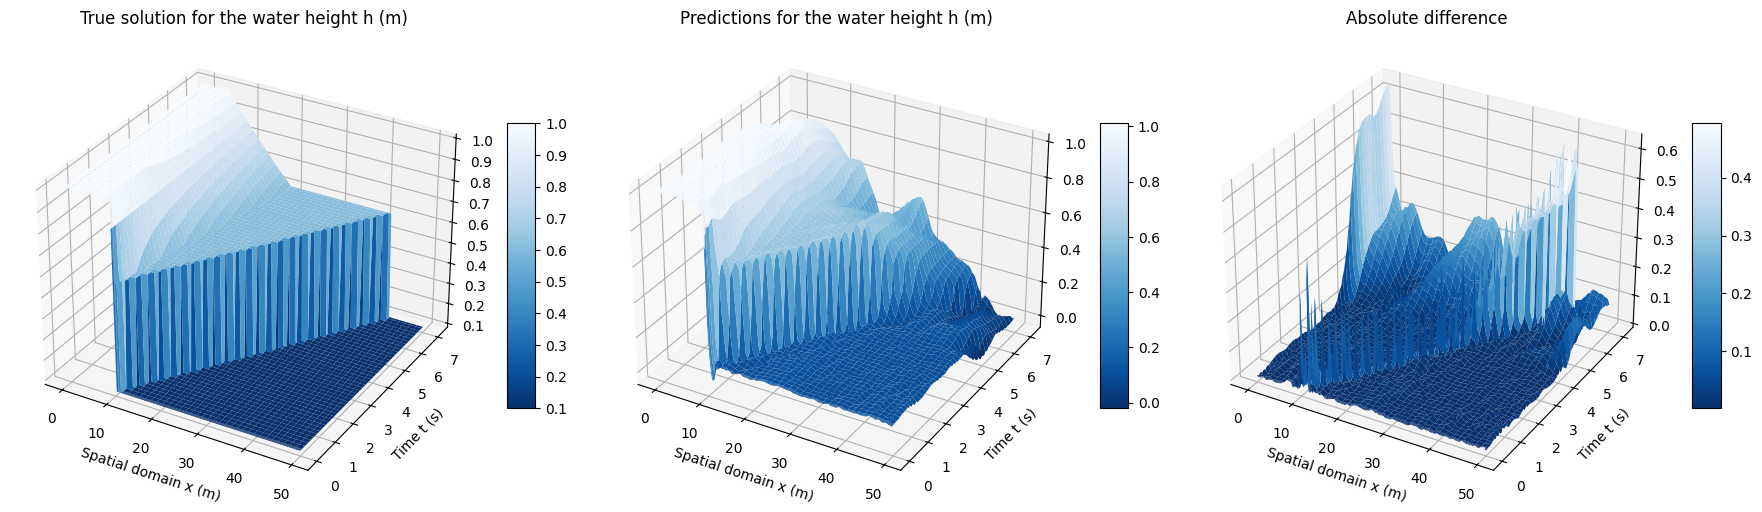

In [36]:
# Prepare grid
X, T = np.meshgrid(mesh, time_all[1:].squeeze())

# Plot the output, predictions and absolute error
fig = plt.figure(figsize=(18, 6))

cmap = 'Blues_r'

# Plot predictions in 3D
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, T, u[:, 0, :], cmap=cmap)
ax1.set_title("True solution for the water height h (m)")
ax1.set_xlabel("Spatial domain x (m)")
ax1.set_ylabel("Time t (s)")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# Plot true solution in 3D
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, T, pred_all[:, 0, :], cmap=cmap)
ax2.set_title("Predictions for the water height h (m)")
ax2.set_xlabel("Spatial domain x (m)")
ax2.set_ylabel("Time t (s)")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

# Plot difference in 3D
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, T, np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
ax3.set_title("Absolute difference ")
ax3.set_xlabel("Spatial domain x (m)")
ax3.set_ylabel("Time t (s)")
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

plt.tight_layout()

if save:
    plt.savefig(f'plots/torotest1_pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}_3D.pdf', format='pdf')

plt.show()


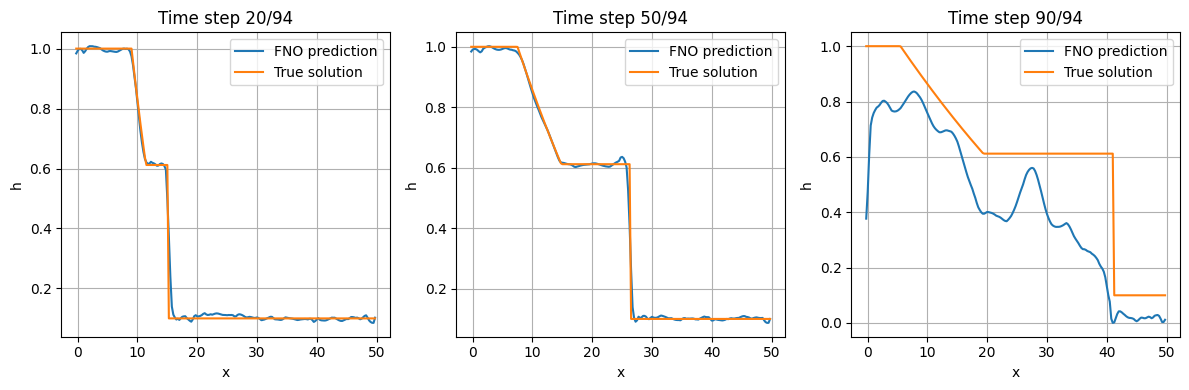

In [37]:
# Plot for some time steps
indices = [20, 50, 90]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(mesh, pred_all[indices[0], 0, :], label='FNO prediction')
plt.plot(mesh, u[indices[0], 0, :], label='True solution')
plt.xlabel('x')
plt.ylabel('h')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[0]}/{n}")

plt.subplot(1, 3, 2)
plt.plot(mesh, pred_all[indices[1], 0, :], label='FNO prediction')
plt.plot(mesh, u[indices[1], 0, :], label='True solution')
plt.xlabel('x')
plt.ylabel('h')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[1]}/{n}")

plt.subplot(1, 3, 3)
plt.plot(mesh, pred_all[indices[2], 0, :], label='FNO prediction')
plt.plot(mesh, u[indices[2], 0, :], label='True solution')
plt.xlabel('x')
plt.ylabel('h')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[2]}/{n}")

plt.tight_layout()

if save:
    plt.savefig(f'plots/torotest1_pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}_timesteps.pdf', format='pdf')

plt.show()

(94,)


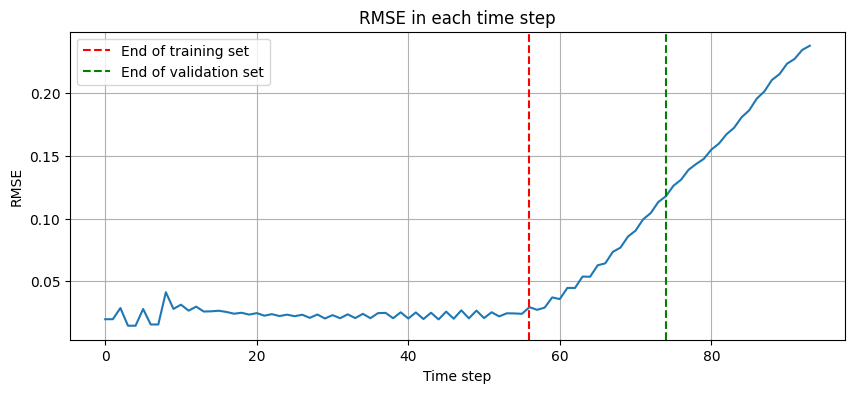

In [38]:
# Plot the RMSE in each time step
rmse = np.sqrt(np.mean((pred_all - u) ** 2, axis=(1, 2)))
print(rmse.shape)

plt.figure(figsize=(10, 4))
plt.plot(rmse)
plt.axvline(x=n_train, color='r', linestyle='--', label='End of training set')
plt.axvline(x=n_train + n_val, color='g', linestyle='--', label='End of validation set')
plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('RMSE in each time step')
plt.legend()
plt.grid()

if save:
    plt.savefig(f'plots/torotest1_rmse_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()